In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!head -n 10 UNSW_NB15_training-set.csv

﻿id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,dload,sloss,dloss,sinpkt,dinpkt,sjit,djit,swin,stcpb,dtcpb,dwin,tcprtt,synack,ackdat,smean,dmean,trans_depth,response_body_len,ct_srv_src,ct_state_ttl,ct_dst_ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
1,0.121478,tcp,-,FIN,6,4,258,172,74.08749,252,254,14158.94238,8495.365234,0,0,24.2956,8.375,30.177547,11.830604,255,621772692,2202533631,255,0,0,0,43,43,0,0,1,0,1,1,1,1,0,0,0,1,1,0,Normal,0
2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,252,8395.112305,503571.3125,2,17,49.915,15.432865,61.426934,1387.77833,255,1417884146,3077387971,255,0,0,0,52,1106,0,0,43,1,1,1,1,2,0,0,0,1,6,0,Normal,0
3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,252,1572.271851,60929.23047,1,6,231.875571,102.737203,17179.58686,11420.92623,255,2116150707,2963114973,255,0.111897,0.061458,0.050439,46,824,0,0,7,1,2,1,1,3,0,0,0,2,6,0,Normal

In [ ]:
import pandas as pd

# -------------------------
# 1️⃣ KDD Cup 1999
# -------------------------
kdd_columns = [
    'duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
    'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
    'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
    'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
    'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate','label'
]

# Load KDD datasets
kdd_train = pd.read_csv('kddcup.data_10_percent', names=kdd_columns)
kdd_test = pd.read_csv('corrected', names=kdd_columns)

# Convert labels to binary: 0=normal, 1=attack
kdd_train['label'] = kdd_train['label'].apply(lambda x: 0 if x.strip() == 'normal.' else 1)
kdd_test['label'] = kdd_test['label'].apply(lambda x: 0 if x.strip() == 'normal.' else 1)

print("✅ KDD train shape:", kdd_train.shape)
print("✅ KDD test shape:", kdd_test.shape)

# -------------------------
# 2️⃣ UNSW-NB15
# -------------------------
# Use engine='python' to avoid parsing errors
unsw_train = pd.read_csv('UNSW_NB15_training-set.csv', engine='python')
unsw_test = pd.read_csv('UNSW_NB15_testing-set.csv', engine='python')

# Check label column name
print("Columns in UNSW train:", unsw_train.columns)

# Convert labels to binary: Normal=0, Attack=1
# Adjust the column name if needed; often it's 'label' or 'attack_cat'
label_column = 'label'  # change if your CSV uses a different name
unsw_train['label'] = unsw_train[label_column].apply(lambda x: 0 if str(x).strip().lower()=='normal' else 1)
unsw_test['label'] = unsw_test[label_column].apply(lambda x: 0 if str(x).strip().lower()=='normal' else 1)

print("✅ UNSW train shape:", unsw_train.shape)
print("✅ UNSW test shape:", unsw_test.shape)

✅ KDD train shape: (494021, 42)
✅ KDD test shape: (311029, 42)
Columns in UNSW train: Index(['id', 'dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')
✅ UNSW train shape: (175341, 45)
✅ UNSW test shape: (82332, 45)


In [ ]:
# KDD features and labels
X_kdd_train = kdd_train.drop('label', axis=1)
y_kdd_train = kdd_train['label']
X_kdd_test = kdd_test.drop('label', axis=1)
y_kdd_test = kdd_test['label']

# UNSW features and labels
feature_cols = [col for col in unsw_train.columns if col not in ['label', 'attack_cat', 'id']]
X_unsw_train = unsw_train[feature_cols]
y_unsw_train = unsw_train['label']
X_unsw_test = unsw_test[feature_cols]
y_unsw_test = unsw_test['label']

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# KDD categorical features
kdd_cat_cols = ['protocol_type','service','flag']
kdd_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_kdd_train_cat = kdd_encoder.fit_transform(X_kdd_train[kdd_cat_cols])
X_kdd_test_cat = kdd_encoder.transform(X_kdd_test[kdd_cat_cols])

# Drop original categorical columns and concat one-hot
X_kdd_train = pd.concat([X_kdd_train.drop(kdd_cat_cols, axis=1).reset_index(drop=True),
                         pd.DataFrame(X_kdd_train_cat)], axis=1)
X_kdd_test = pd.concat([X_kdd_test.drop(kdd_cat_cols, axis=1).reset_index(drop=True),
                        pd.DataFrame(X_kdd_test_cat)], axis=1)

# UNSW categorical features
unsw_cat_cols = ['proto','service','state']
unsw_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
X_unsw_train_cat = unsw_encoder.fit_transform(X_unsw_train[unsw_cat_cols])
X_unsw_test_cat = unsw_encoder.transform(X_unsw_test[unsw_cat_cols])

# Drop original categorical columns and concat one-hot
X_unsw_train = pd.concat([X_unsw_train.drop(unsw_cat_cols, axis=1).reset_index(drop=True),
                          pd.DataFrame(X_unsw_train_cat)], axis=1)
X_unsw_test = pd.concat([X_unsw_test.drop(unsw_cat_cols, axis=1).reset_index(drop=True),
                         pd.DataFrame(X_unsw_test_cat)], axis=1)

In [ ]:
# Make all column names strings
X_kdd_train.columns = X_kdd_train.columns.astype(str)
X_kdd_test.columns = X_kdd_test.columns.astype(str)

In [ ]:
X_kdd_train_np = X_kdd_train.values
X_kdd_test_np = X_kdd_test.values

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report

iso = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso.fit(X_kdd_train_np)

# Predict anomalies
y_pred = iso.predict(X_kdd_test_np)
y_pred = [0 if i==1 else 1 for i in y_pred]  # convert to 0=normal, 1=anomaly

print(classification_report(y_kdd_test, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.92      0.35     60593
           1       0.91      0.19      0.31    250436

    accuracy                           0.33    311029
   macro avg       0.56      0.55      0.33    311029
weighted avg       0.77      0.33      0.32    311029



In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.ensemble import IsolationForest, RandomForestClassifier
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam

In [ ]:
# Convert to NumPy
X_kdd_train_np = X_kdd_train.values
X_kdd_test_np = X_kdd_test.values

iso = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
iso.fit(X_kdd_train_np)

y_pred_iso = iso.predict(X_kdd_test_np)
y_pred_iso = [0 if i==1 else 1 for i in y_pred_iso]  # convert to 0=normal, 1=anomaly

print("Isolation Forest (KDD) Results:")
print(classification_report(y_kdd_test, y_pred_iso))

Isolation Forest (KDD) Results:
              precision    recall  f1-score   support

           0       0.22      0.92      0.35     60593
           1       0.91      0.19      0.31    250436

    accuracy                           0.33    311029
   macro avg       0.56      0.55      0.33    311029
weighted avg       0.77      0.33      0.32    311029



In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_kdd_train_np, y_kdd_train)

y_pred_rf = rf.predict(X_kdd_test_np)
print("Random Forest (KDD) Results:")
print(classification_report(y_kdd_test, y_pred_rf))

Random Forest (KDD) Results:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84     60593
           1       1.00      0.91      0.95    250436

    accuracy                           0.93    311029
   macro avg       0.86      0.95      0.90    311029
weighted avg       0.95      0.93      0.93    311029



In [ ]:
import pandas as pd

# Load dataset
vaultsphere_df = pd.read_csv("synthetic_vaultsphere_logs.csv")

In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
vaultsphere_df['resource_id_encoded'] = le.fit_transform(vaultsphere_df['resource_id'])

# Now use numeric column
vault_num = vaultsphere_df[['resource_id_encoded']].values

In [ ]:
from sklearn.preprocessing import OneHotEncoder

cat_cols = ['event_type', 'status']
encoder = OneHotEncoder(sparse_output=False)
vault_cat = encoder.fit_transform(vaultsphere_df[cat_cols])

In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

X_vault = np.hstack([vault_num, vault_cat])

scaler = MinMaxScaler()
X_vault_scaled = scaler.fit_transform(X_vault)

In [ ]:
seq_length = 10  # number of events in a sequence

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data)-seq_length):
        sequences.append(data[i:i+seq_length])
    return np.array(sequences)

X_seq = create_sequences(X_vault_scaled, seq_length)

print("LSTM input shape:", X_seq.shape)  # should be (num_sequences, seq_length, num_features)

LSTM input shape: (16258, 10, 12)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

timesteps, features = X_seq.shape[1], X_seq.shape[2]

model = Sequential([
    LSTM(64, activation='relu', input_shape=(timesteps, features), return_sequences=False),
    RepeatVector(timesteps),
    LSTM(64, activation='relu', return_sequences=True),
    TimeDistributed(Dense(features))
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        19,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 10, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 10, 12)         │           780 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,516 (209.05 KB)

 Trainable params: 53,516 (209.05 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_seq, X_seq,
    epochs=20,
    batch_size=256,
    validation_split=0.1
)

Epoch 1/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.1437 - val_loss: 0.0924
Epoch 2/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0905 - val_loss: 0.0824
Epoch 3/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0837 - val_loss: 0.0799
Epoch 4/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0815 - val_loss: 0.0785
Epoch 5/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0802 - val_loss: 0.0770
Epoch 6/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0791 - val_loss: 0.0758
Epoch 7/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0778 - val_loss: 0.0743
Epoch 8/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0762 - val_loss: 0.0732
Epoch 9/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0755 - val_loss: 0.0732
Epoch 10/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0743 - val_loss: 0.0710
Epoch 11/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0729 - val_loss: 0.0700
Epoch 12/20
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0720 - val_

In [ ]:
# Predict reconstruction
X_pred = model.predict(X_seq)

# Compute MSE per sequence
mse = np.mean(np.power(X_seq - X_pred, 2), axis=(1,2))

# Set threshold (95th percentile)
threshold = np.percentile(mse, 95)

# Flag anomalies
anomalies = mse > threshold

print(f"Detected {anomalies.sum()} anomalous sequences in VaultSphere logs")

509/509 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
Detected 813 anomalous sequences in VaultSphere logs


In [ ]:
anomaly_indices = np.where(anomalies)[0]  # indices of anomalous sequences
sequence_map = vaultsphere_df.iloc[seq_length-1:].reset_index()  # map sequences to original rows

anomalous_rows = sequence_map.iloc[anomaly_indices]
print(anomalous_rows[['timestamp','tenant_id','user_id','event_type','status']].head(10))

               timestamp  tenant_id  user_id    event_type   status
143  2025-08-27 03:54:35          2  T02U038  ADMIN_ACTION  SUCCESS
144  2025-08-27 04:07:11          1  T01U003         ORDER  SUCCESS
145  2025-08-27 04:07:40          1  T01U010        UPDATE  SUCCESS
146  2025-08-27 04:13:11          2  T02U021      DOWNLOAD  FAILURE
147  2025-08-27 04:20:46          2  T02U044      DOWNLOAD  SUCCESS
148  2025-08-27 04:37:29          1  T01U010        UPDATE  SUCCESS
149  2025-08-27 04:39:07          1  T01U011         ORDER  SUCCESS
214  2025-08-27 09:50:35          1  T01U033         LOGIN  SUCCESS
215  2025-08-27 09:51:47          1  T01U035        UPDATE  SUCCESS
216  2025-08-27 09:53:17          2  T02U009  ADMIN_ACTION  SUCCESS


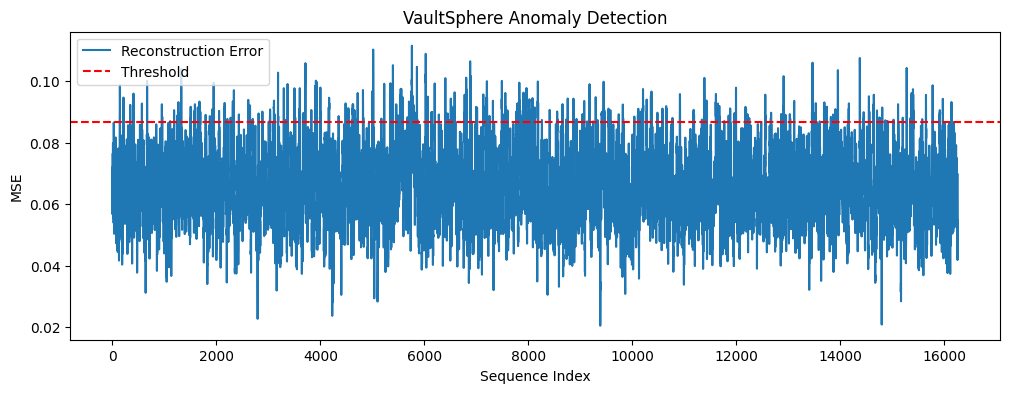

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(mse, label='Reconstruction Error')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold')
plt.title("VaultSphere Anomaly Detection")
plt.xlabel("Sequence Index")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [ ]:
from sklearn.preprocessing import LabelEncoder

vaultsphere_df['resource_id_enc'] = LabelEncoder().fit_transform(vaultsphere_df['resource_id'])

# Combine numeric + categorical
vault_num = vaultsphere_df[['resource_id_enc']].values
X_vault_if = np.hstack([vault_num, vault_cat])

# Normalize
scaler = MinMaxScaler()
X_vault_if_scaled = scaler.fit_transform(X_vault_if)

# Train Isolation Forest
iso_vault = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_vault.fit(X_vault_if_scaled)

# Predict anomalies
y_pred_if = iso_vault.predict(X_vault_if_scaled)
y_pred_if = np.array([0 if i==1 else 1 for i in y_pred_if])

print(f"Detected {y_pred_if.sum()} anomalies using Isolation Forest")

Detected 814 anomalies using Isolation Forest


In [ ]:
lstm_anomalies = anomalies.sum()
print(f"Detected {lstm_anomalies} anomalies using LSTM Autoencoder")

Detected 813 anomalies using LSTM Autoencoder


In [ ]:
print(f"Isolation Forest anomalies: {y_pred_if.sum()}")
print(f"LSTM Autoencoder anomalies: {lstm_anomalies}")

Isolation Forest anomalies: 814
LSTM Autoencoder anomalies: 813


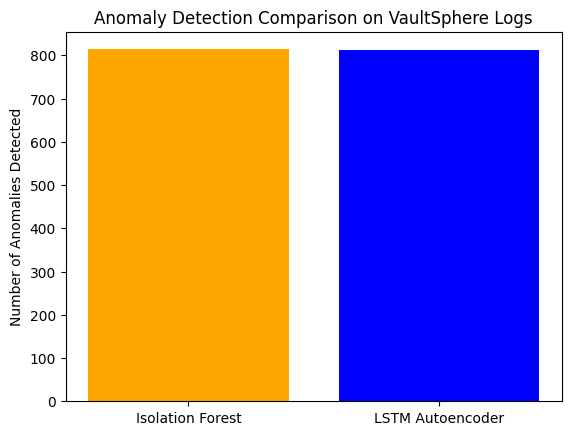

In [ ]:
import matplotlib.pyplot as plt

plt.bar(['Isolation Forest', 'LSTM Autoencoder'], [y_pred_if.sum(), lstm_anomalies], color=['orange', 'blue'])
plt.ylabel('Number of Anomalies Detected')
plt.title('Anomaly Detection Comparison on VaultSphere Logs')
plt.show()

Isolation Forest anomalies: 814
LSTM Autoencoder anomalies: 813


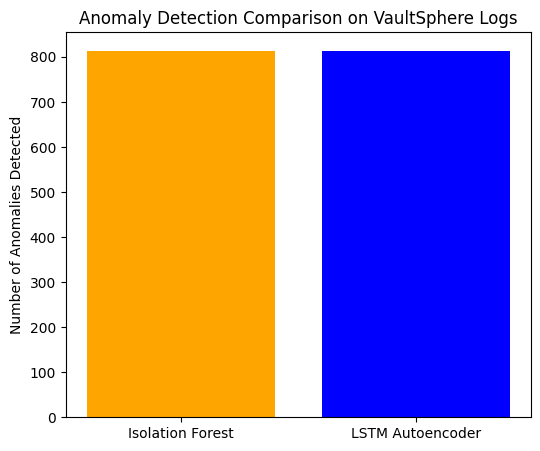

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest

# --- Prepare Isolation Forest data ---
# Encode resource_id
vaultsphere_df['resource_id_enc'] = LabelEncoder().fit_transform(vaultsphere_df['resource_id'])

# Combine numeric + categorical
vault_num = vaultsphere_df[['resource_id_enc']].values
X_vault_if = np.hstack([vault_num, vault_cat])

# Normalize
scaler = MinMaxScaler()
X_vault_if_scaled = scaler.fit_transform(X_vault_if)

# Train Isolation Forest
iso_vault = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_vault.fit(X_vault_if_scaled)

# Predict anomalies
y_pred_if = iso_vault.predict(X_vault_if_scaled)
y_pred_if = np.array([0 if i==1 else 1 for i in y_pred_if])
iso_count = y_pred_if.sum()

# --- LSTM Autoencoder results ---
# X_seq, anomalies already computed from LSTM model
lstm_count = anomalies.sum()

# --- Print comparison ---
print(f"Isolation Forest anomalies: {iso_count}")
print(f"LSTM Autoencoder anomalies: {lstm_count}")

# --- Plot comparison ---
plt.figure(figsize=(6,5))
plt.bar(['Isolation Forest', 'LSTM Autoencoder'], [iso_count, lstm_count], color=['orange', 'blue'])
plt.ylabel('Number of Anomalies Detected')
plt.title('Anomaly Detection Comparison on VaultSphere Logs')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

# y_pred_if: Isolation Forest predictions (0=normal, 1=anomaly)
# anomalies: LSTM Autoencoder predictions (boolean array, True=anomaly)

# Align lengths: LSTM sequences are shorter due to seq_length
seq_length = 10
lstm_flags_full = np.zeros(len(vaultsphere_df), dtype=int)
for i in range(len(anomalies)):
    if anomalies[i]:
        lstm_flags_full[i:i+seq_length] = 1

# Find events detected by LSTM but missed by Isolation Forest
lstm_only_idx = np.where((lstm_flags_full == 1) & (y_pred_if == 0))[0]

# Extract those sequences/events
lstm_only_events = vaultsphere_df.iloc[lstm_only_idx]

print(f"Number of events detected only by LSTM: {len(lstm_only_events)}")
lstm_only_events.head(10)  # show first 10 for inspection

# Optional: save to CSV for your paper
lstm_only_events.to_csv('lstm_only_anomalies.csv', index=False)

Number of events detected only by LSTM: 2734


In [ ]:
import pandas as pd
vaultsphere_df = pd.read_csv("synthetic_vaultsphere_logs.csv")

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models

# ============================
# Step 2: Preprocess features
# ============================

# Load data
vaultsphere_df = pd.read_csv("synthetic_vaultsphere_logs.csv")

# One-hot encode categorical columns (adjust columns as needed)
df_encoded = pd.get_dummies(vaultsphere_df, drop_first=True)

# Scale features
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_encoded)

print("Shape after encoding + scaling:", df_scaled.shape)

# ============================
# Step 3: Build sequences
# ============================
seq_length = 50  # sequence length for LSTM

def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        seq = data[i : (i + seq_length)]
        sequences.append(seq)
    return np.array(sequences)

X_seq = create_sequences(df_scaled, seq_length)
print("Shape of sequences for LSTM:", X_seq.shape)

# ============================
# Step 4: Build LSTM Autoencoder
# ============================
timesteps = X_seq.shape[1]
n_features = X_seq.shape[2]

inputs = layers.Input(shape=(timesteps, n_features))
encoded = layers.LSTM(64, activation="relu", return_sequences=False)(inputs)
repeat = layers.RepeatVector(timesteps)(encoded)
decoded = layers.LSTM(64, activation="relu", return_sequences=True)(repeat)
outputs = layers.TimeDistributed(layers.Dense(n_features))(decoded)

lstm_autoencoder = models.Model(inputs, outputs)
lstm_autoencoder.compile(optimizer="adam", loss="mse")

lstm_autoencoder.summary()

# Train (unsupervised)
history = lstm_autoencoder.fit(
    X_seq, X_seq,
    epochs=5,        # increase for better results
    batch_size=64,
    validation_split=0.1,
    shuffle=True
)

# ============================
# Step 5: Get anomaly predictions
# ============================
# Reconstruction errors
X_pred = lstm_autoencoder.predict(X_seq)
mse = np.mean(np.power(X_seq - X_pred, 2), axis=(1,2))

# Threshold = mean + 3*std (you can tune this)
threshold = np.mean(mse) + 3*np.std(mse)
y_pred_lstm = (mse > threshold).astype(int)

print("y_pred_lstm shape:", y_pred_lstm.shape)
print("Number of anomalies detected by LSTM:", y_pred_lstm.sum())

Shape after encoding + scaling: (16268, 17537)


In [ ]:
# Align Isolation Forest predictions with LSTM sequences
y_pred_if_seq = y_pred_if[seq_length:]  # drop first seq_length elements

# Now shapes should match
print("IF seq shape:", y_pred_if_seq.shape)
print("LSTM shape:", y_pred_lstm.shape)

# Compare anomalies
lstm_only = np.logical_and(y_pred_lstm==1, y_pred_if_seq==0)
num_lstm_only = lstm_only.sum()
print(f"Number of events detected only by LSTM: {num_lstm_only}")

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -----------------------------
# LSTM vs Isolation Forest comparison
# -----------------------------

# Align IF predictions to LSTM sequences
y_pred_if_seq = y_pred_if[seq_length:]  # drop first seq_length events
y_pred_lstm = anomalies.astype(int)     # LSTM anomalies from previous step

# LSTM-only anomalies
lstm_only = np.logical_and(y_pred_lstm==1, y_pred_if_seq==0)
num_lstm_only = lstm_only.sum()

# Summary table
summary = pd.DataFrame({
    'Method': ['Isolation Forest', 'LSTM Autoencoder', 'LSTM-only'],
    'Detected Anomalies': [y_pred_if_seq.sum(), y_pred_lstm.sum(), num_lstm_only]
})
print(summary)

# Bar plot for visual comparison
plt.figure(figsize=(8,5))
plt.bar(summary['Method'], summary['Detected Anomalies'], color=['orange', 'skyblue', 'red'])
plt.title('VaultSphere Synthetic Logs: Anomaly Detection Comparison')
plt.ylabel('Number of Anomalous Sequences')
plt.show()

# Save LSTM-only sequences for further analysis
lstm_only_sequences = X_seq[lstm_only]
np.save('lstm_only_sequences.npy', lstm_only_sequences)

print(f"Saved {num_lstm_only} LSTM-only anomalous sequences to 'lstm_only_sequences.npy'")

In [ ]:
# Extract VaultSphere info for LSTM-only sequences
seq_indices = np.arange(len(y_pred_lstm))
lstm_only_indices = seq_indices[lstm_only]

# Map back to original DataFrame events
# Each sequence is seq_length long, take the starting index
event_indices = lstm_only_indices

# Since sequences overlap, we can consider the first event of each anomalous sequence
lstm_events = vaultsphere_df.iloc[event_indices]

# Aggregate per tenant
tenant_summary = lstm_events.groupby('tenant_id').size().reset_index(name='LSTM_only_anomalies')
print("Per-Tenant LSTM-only anomaly counts:")
print(tenant_summary)

# Aggregate per user
user_summary = lstm_events.groupby(['tenant_id', 'user_id']).size().reset_index(name='LSTM_only_anomalies')
print("\nPer-User LSTM-only anomaly counts (sample):")
print(user_summary.head(20))  # print top 20 rows

# Optional: save for your paper
tenant_summary.to_csv('lstm_only_anomalies_per_tenant.csv', index=False)
user_summary.to_csv('lstm_only_anomalies_per_user.csv', index=False)
print("\nSaved per-tenant and per-user LSTM-only anomalies CSV files.")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# --- Per Tenant Comparison ---
# Total anomalies per tenant for LSTM
lstm_tenant_counts = lstm_events.groupby('tenant_id').size()
# Total anomalies per tenant for Isolation Forest
iso_events_df = vaultsphere_df.copy()
iso_events_df['anomaly_if'] = y_pred_if
iso_tenant_counts = iso_events_df[iso_events_df['anomaly_if']==1].groupby('tenant_id').size()

# Combine into DataFrame for plotting
tenant_df = pd.DataFrame({
    'Tenant': lstm_tenant_counts.index,
    'LSTM': lstm_tenant_counts.values,
    'IsolationForest': iso_tenant_counts.reindex(lstm_tenant_counts.index, fill_value=0).values
})

tenant_df.plot(x='Tenant', kind='bar', figsize=(10,6))
plt.title("Anomalies per Tenant: LSTM vs Isolation Forest")
plt.ylabel("Number of anomalies")
plt.xlabel("Tenant ID")
plt.xticks(rotation=0)
plt.show()

# --- Per User Comparison ---
# Take top 20 users with most LSTM-only anomalies
top_users = user_summary.sort_values('LSTM_only_anomalies', ascending=False).head(20)
plt.figure(figsize=(12,6))
sns.barplot(x='user_id', y='LSTM_only_anomalies', hue='tenant_id', data=top_users, dodge=True)
plt.title("Top 20 Users with LSTM-only Anomalies")
plt.ylabel("Number of anomalies")
plt.xlabel("User ID")
plt.legend(title='Tenant ID')
plt.show()

In [ ]:
import pandas as pd

# Load datasets
food_df = pd.read_csv('vaultsphere_food.csv')
it_df = pd.read_csv('vaultsphere_it.csv')

print("Food Company shape:", food_df.shape)
print("IT Solutions shape:", it_df.shape)

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import numpy as np

# Label encode resource_id
food_df['resource_id_enc'] = LabelEncoder().fit_transform(food_df['resource_id'])
it_df['resource_id_enc'] = LabelEncoder().fit_transform(it_df['resource_id'])

# One-hot encode event_type and status
cat_cols = ['event_type', 'status']

encoder_food = OneHotEncoder(sparse_output=False)
X_food_cat = encoder_food.fit_transform(food_df[cat_cols])

encoder_it = OneHotEncoder(sparse_output=False)
X_it_cat = encoder_it.fit_transform(it_df[cat_cols])

# Combine numeric + categorical
X_food = np.hstack([food_df[['resource_id_enc']].values, X_food_cat])
X_it = np.hstack([it_df[['resource_id_enc']].values, X_it_cat])

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler_food = MinMaxScaler()
X_food_scaled = scaler_food.fit_transform(X_food)

scaler_it = MinMaxScaler()
X_it_scaled = scaler_it.fit_transform(X_it)

In [ ]:
from sklearn.ensemble import IsolationForest

iso_food = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
y_food_pred = iso_food.fit_predict(X_food_scaled)
y_food_pred = np.array([0 if i==1 else 1 for i in y_food_pred])  # 0=normal, 1=anomaly

iso_it = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
y_it_pred = iso_it.fit_predict(X_it_scaled)
y_it_pred = np.array([0 if i==1 else 1 for i in y_it_pred])

print(f"Food Company anomalies detected: {y_food_pred.sum()}")
print(f"IT Solutions anomalies detected: {y_it_pred.sum()}")

In [ ]:
import matplotlib.pyplot as plt

plt.bar(['Food Company', 'IT Solutions'], [y_food_pred.sum(), y_it_pred.sum()], color=['orange','blue'])
plt.ylabel('Number of Anomalies Detected')
plt.title('Isolation Forest Anomaly Detection - VaultSphere Tenants')
plt.show()

In [ ]:
# Food Company anomalies over time
food_df['anomaly'] = y_food_pred
food_df['timestamp'] = pd.to_datetime(food_df['timestamp'])
food_df.set_index('timestamp', inplace=True)
food_daily = food_df.resample('D')['anomaly'].sum()

# IT Solutions anomalies over time
it_df['anomaly'] = y_it_pred
it_df['timestamp'] = pd.to_datetime(it_df['timestamp'])
it_df.set_index('timestamp', inplace=True)
it_daily = it_df.resample('D')['anomaly'].sum()

plt.figure(figsize=(10,5))
plt.plot(food_daily.index, food_daily.values, label='Food Company', color='orange')
plt.plot(it_daily.index, it_daily.values, label='IT Solutions', color='blue')
plt.xlabel('Date')
plt.ylabel('Anomalies Detected')
plt.title('Daily Anomalies - VaultSphere Tenants')
plt.legend()
plt.show()

In [ ]:
import pandas as pd

# Load the correct files
food_df = pd.read_csv('vaultsphere_food.csv')
it_df = pd.read_csv('vaultsphere_it.csv')

print("Food Company shape:", food_df.shape)
print("IT Solutions shape:", it_df.shape)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

# Load datasets
food_df = pd.read_csv('vaultsphere_food.csv')
it_df = pd.read_csv('vaultsphere_it.csv')

# Function to prepare tenant data for LSTM
def prepare_tenant_data(df, cat_cols, seq_length=10):
    # Encode categorical features
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cat_data = encoder.fit_transform(df[cat_cols])

    # Encode resource_id
    df['resource_id_enc'] = LabelEncoder().fit_transform(df['resource_id'])
    num_data = df[['resource_id_enc']].values

    # Combine numeric + categorical
    X = np.hstack([num_data, cat_data])

    # Normalize features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # Create sequences
    sequences = [X_scaled[i:i+seq_length] for i in range(len(X_scaled) - seq_length)]
    return np.array(sequences)

# Parameters
seq_length = 10
cat_cols = ['event_type', 'status']

# Prepare sequences for each tenant
X_food_seq = prepare_tenant_data(food_df, cat_cols, seq_length)
X_it_seq = prepare_tenant_data(it_df, cat_cols, seq_length)

# Function to build LSTM Autoencoder
def build_lstm_autoencoder(timesteps, features):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(timesteps, features), return_sequences=False),
        RepeatVector(timesteps),
        LSTM(64, activation='relu', return_sequences=True),
        TimeDistributed(Dense(features))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Build models
timesteps, features = X_food_seq.shape[1], X_food_seq.shape[2]
food_model = build_lstm_autoencoder(timesteps, features)
it_model = build_lstm_autoencoder(timesteps, features)

# Train models
food_history = food_model.fit(X_food_seq, X_food_seq, epochs=20, batch_size=256, validation_split=0.1)
it_history = it_model.fit(X_it_seq, X_it_seq, epochs=20, batch_size=256, validation_split=0.1)

# Function to detect anomalies
def detect_anomalies(model, X_seq, threshold_percentile=95):
    X_pred = model.predict(X_seq)
    mse = np.mean(np.power(X_seq - X_pred, 2), axis=(1,2))
    threshold = np.percentile(mse, threshold_percentile)
    anomalies = mse > threshold
    return anomalies, threshold

# Detect anomalies for each tenant
food_anomalies, food_thresh = detect_anomalies(food_model, X_food_seq)
it_anomalies, it_thresh = detect_anomalies(it_model, X_it_seq)

print(f"Food Company: {food_anomalies.sum()} anomalous sequences detected")
print(f"IT Solutions: {it_anomalies.sum()} anomalous sequences detected")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam

# Load datasets
food_df = pd.read_csv('vaultsphere_food.csv')
it_df = pd.read_csv('vaultsphere_it.csv')

# Function to prepare tenant data
def prepare_tenant_data(df, cat_cols, seq_length=10):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cat_data = encoder.fit_transform(df[cat_cols])

    df['resource_id_enc'] = LabelEncoder().fit_transform(df['resource_id'])
    num_data = df[['resource_id_enc']].values

    X = np.hstack([num_data, cat_data])

    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    sequences = [X_scaled[i:i+seq_length] for i in range(len(X_scaled) - seq_length)]
    return np.array(sequences), X_scaled

# Parameters
seq_length = 10
cat_cols = ['event_type', 'status']

# Prepare sequences
X_food_seq, X_food_scaled = prepare_tenant_data(food_df, cat_cols, seq_length)
X_it_seq, X_it_scaled = prepare_tenant_data(it_df, cat_cols, seq_length)

# Build LSTM Autoencoder
def build_lstm_autoencoder(timesteps, features):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(timesteps, features), return_sequences=False),
        RepeatVector(timesteps),
        LSTM(64, activation='relu', return_sequences=True),
        TimeDistributed(Dense(features))
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Train LSTM models
timesteps, features = X_food_seq.shape[1], X_food_seq.shape[2]
food_model = build_lstm_autoencoder(timesteps, features)
it_model = build_lstm_autoencoder(timesteps, features)

food_model.fit(X_food_seq, X_food_seq, epochs=20, batch_size=256, validation_split=0.1)
it_model.fit(X_it_seq, X_it_seq, epochs=20, batch_size=256, validation_split=0.1)

# Detect anomalies with LSTM
def detect_lstm_anomalies(model, X_seq, percentile=95):
    X_pred = model.predict(X_seq)
    mse = np.mean((X_seq - X_pred) ** 2, axis=(1,2))
    threshold = np.percentile(mse, percentile)
    anomalies = mse > threshold
    return anomalies, threshold

food_lstm_anom, food_lstm_thresh = detect_lstm_anomalies(food_model, X_food_seq)
it_lstm_anom, it_lstm_thresh = detect_lstm_anomalies(it_model, X_it_seq)

# Detect anomalies with Isolation Forest
def detect_if_anomalies(X_scaled, contamination=0.05):
    iso = IsolationForest(n_estimators=100, contamination=contamination, random_state=42)
    iso.fit(X_scaled)
    y_pred = iso.predict(X_scaled)
    y_pred = np.array([0 if i==1 else 1 for i in y_pred])
    return y_pred

food_if_anom = detect_if_anomalies(X_food_scaled)
it_if_anom = detect_if_anomalies(X_it_scaled)

# Summary
summary = pd.DataFrame({
    'Tenant': ['Food Company', 'IT Solutions'],
    'LSTM Anomalies': [food_lstm_anom.sum(), it_lstm_anom.sum()],
    'Isolation Forest Anomalies': [food_if_anom.sum(), it_if_anom.sum()]
})
print(summary)

# Bar Plot
summary.set_index('Tenant').plot(kind='bar', figsize=(8,6))
plt.title("Anomalies Detected: LSTM vs Isolation Forest")
plt.ylabel("Number of Anomalous Sequences")
plt.xticks(rotation=0)
plt.show()

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you already have:
# food_lstm_anom, it_lstm_anom, food_if_anom, it_if_anom

# --- Align sequence lengths ---
min_food_len = min(len(food_lstm_anom), len(food_if_anom))
food_lstm_aligned = food_lstm_anom[:min_food_len]
food_if_aligned = food_if_anom[:min_food_len]

min_it_len = min(len(it_lstm_anom), len(it_if_anom))
it_lstm_aligned = it_lstm_anom[:min_it_len]
it_if_aligned = it_if_anom[:min_it_len]

# --- LSTM-only anomalies ---
food_lstm_only = np.logical_and(food_lstm_aligned, food_if_aligned == 0)
it_lstm_only = np.logical_and(it_lstm_aligned, it_if_aligned == 0)

print(f"Food Company: {food_lstm_only.sum()} sequences detected only by LSTM")
print(f"IT Solutions: {it_lstm_only.sum()} sequences detected only by LSTM")

# --- Prepare summary table ---
summary = pd.DataFrame({
    'Tenant': ['Food Company', 'IT Solutions'],
    'Total IF Anomalies': [food_if_aligned.sum(), it_if_aligned.sum()],
    'Total LSTM Anomalies': [food_lstm_aligned.sum(), it_lstm_aligned.sum()],
    'LSTM-only Anomalies': [food_lstm_only.sum(), it_lstm_only.sum()]
})
print(summary)

# --- Plot comparison ---
x_labels = ['Isolation Forest', 'LSTM', 'LSTM-only']
food_counts = [food_if_aligned.sum(), food_lstm_aligned.sum(), food_lstm_only.sum()]
it_counts = [it_if_aligned.sum(), it_lstm_aligned.sum(), it_lstm_only.sum()]

x = np.arange(len(x_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, food_counts, width, label='Food Company')
rects2 = ax.bar(x + width/2, it_counts, width, label='IT Solutions')

ax.set_ylabel('Number of Anomalous Sequences')
ax.set_title('LSTM vs Isolation Forest Anomalies')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3), textcoords='offset points',
                ha='center', va='bottom')

plt.show()

# --- Save LSTM-only sequences for further analysis ---
food_df_lstm_only = pd.DataFrame(food_df.iloc[:min_food_len][food_lstm_only])
it_df_lstm_only = pd.DataFrame(it_df.iloc[:min_it_len][it_lstm_only])

food_df_lstm_only.to_csv('food_lstm_only.csv', index=False)
it_df_lstm_only.to_csv('it_lstm_only.csv', index=False)

print("LSTM-only sequences saved as CSV files.")

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- Load datasets ---
food_df = pd.read_csv('vaultsphere_food.csv')
it_df = pd.read_csv('vaultsphere_it.csv')

# --- Prepare sequences function ---
def prepare_tenant_data(df, cat_cols, seq_length=10):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cat_data = encoder.fit_transform(df[cat_cols])
    df['resource_id_enc'] = LabelEncoder().fit_transform(df['resource_id'])
    num_data = df[['resource_id_enc']].values
    X = np.hstack([num_data, cat_data])
    X_scaled = MinMaxScaler().fit_transform(X)

    sequences = []
    for i in range(len(X_scaled)-seq_length):
        sequences.append(X_scaled[i:i+seq_length])
    return np.array(sequences)

seq_length = 10
cat_cols = ['event_type', 'status']

X_food_seq = prepare_tenant_data(food_df, cat_cols, seq_length)
X_it_seq = prepare_tenant_data(it_df, cat_cols, seq_length)

# --- Build LSTM Autoencoder ---
def build_lstm_autoencoder(timesteps, features):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(timesteps, features), return_sequences=False),
        RepeatVector(timesteps),
        LSTM(64, activation='relu', return_sequences=True),
        TimeDistributed(Dense(features))
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

timesteps, features = X_food_seq.shape[1], X_food_seq.shape[2]
food_model = build_lstm_autoencoder(timesteps, features)
it_model = build_lstm_autoencoder(timesteps, features)

# --- Train LSTM models ---
food_model.fit(X_food_seq, X_food_seq, epochs=20, batch_size=256, validation_split=0.1)
it_model.fit(X_it_seq, X_it_seq, epochs=20, batch_size=256, validation_split=0.1)

# --- Detect anomalies using LSTM ---
def detect_lstm_anomalies(model, X_seq, percentile=95):
    X_pred = model.predict(X_seq)
    mse = np.mean(np.power(X_seq - X_pred, 2), axis=(1,2))
    threshold = np.percentile(mse, percentile)
    anomalies = mse > threshold
    return anomalies, threshold

food_lstm_anom, food_thresh = detect_lstm_anomalies(food_model, X_food_seq)
it_lstm_anom, it_thresh = detect_lstm_anomalies(it_model, X_it_seq)

# --- Detect anomalies using Isolation Forest ---
def detect_if_anomalies(df, cat_cols):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cat_data = encoder.fit_transform(df[cat_cols])
    df['resource_id_enc'] = LabelEncoder().fit_transform(df['resource_id'])
    num_data = df[['resource_id_enc']].values
    X = np.hstack([num_data, cat_data])
    X_scaled = MinMaxScaler().fit_transform(X)

    iso = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    iso.fit(X_scaled)
    y_pred = iso.predict(X_scaled)
    y_pred = np.array([0 if i==1 else 1 for i in y_pred])
    return y_pred

food_if_anom = detect_if_anomalies(food_df, cat_cols)
it_if_anom = detect_if_anomalies(it_df, cat_cols)

# --- Align sequence lengths ---
min_food_len = min(len(food_lstm_anom), len(food_if_anom))
food_lstm_aligned = food_lstm_anom[:min_food_len]
food_if_aligned = food_if_anom[:min_food_len]

min_it_len = min(len(it_lstm_anom), len(it_if_anom))
it_lstm_aligned = it_lstm_anom[:min_it_len]
it_if_aligned = it_if_anom[:min_it_len]

# --- LSTM-only anomalies ---
food_lstm_only = np.logical_and(food_lstm_aligned, food_if_aligned == 0)
it_lstm_only = np.logical_and(it_lstm_aligned, it_if_aligned == 0)

print(f"Food Company: {food_lstm_only.sum()} sequences detected only by LSTM")
print(f"IT Solutions: {it_lstm_only.sum()} sequences detected only by LSTM")

# --- Summary Table ---
summary = pd.DataFrame({
    'Tenant': ['Food Company', 'IT Solutions'],
    'Total IF Anomalies': [food_if_aligned.sum(), it_if_aligned.sum()],
    'Total LSTM Anomalies': [food_lstm_aligned.sum(), it_lstm_aligned.sum()],
    'LSTM-only Anomalies': [food_lstm_only.sum(), it_lstm_only.sum()]
})
print(summary)

# --- Bar Plot ---
x_labels = ['Isolation Forest', 'LSTM', 'LSTM-only']
food_counts = [food_if_aligned.sum(), food_lstm_aligned.sum(), food_lstm_only.sum()]
it_counts = [it_if_aligned.sum(), it_lstm_aligned.sum(), it_lstm_only.sum()]

x = np.arange(len(x_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, food_counts, width, label='Food Company')
rects2 = ax.bar(x + width/2, it_counts, width, label='IT Solutions')

ax.set_ylabel('Number of Anomalous Sequences')
ax.set_title('LSTM vs Isolation Forest Anomalies')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height}',
                xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3), textcoords='offset points',
                ha='center', va='bottom')

plt.show()

# --- Save LSTM-only sequences ---
food_df_lstm_only = food_df.iloc[:min_food_len][food_lstm_only]
it_df_lstm_only = it_df.iloc[:min_it_len][it_lstm_only]

food_df_lstm_only.to_csv('food_lstm_only.csv', index=False)
it_df_lstm_only.to_csv('it_lstm_only.csv', index=False)

print("LSTM-only sequences saved for further analysis.")

In [ ]:
# --- Summarize LSTM-only anomalies ---
def summarize_anomalies(df, lstm_only_mask):
    df_anom = df.iloc[:len(lstm_only_mask)][lstm_only_mask]
    summary = df_anom.groupby(['user_id', 'event_type']).size().reset_index(name='count')
    return df_anom, summary

food_lstm_df, food_summary = summarize_anomalies(food_df, food_lstm_only)
it_lstm_df, it_summary = summarize_anomalies(it_df, it_lstm_only)

print("Food Company LSTM-only anomaly summary:")
print(food_summary.head())

print("\nIT Solutions LSTM-only anomaly summary:")
print(it_summary.head())

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_anomalies(df, lstm_mask):
    if 'is_anomaly' not in df.columns:
        print("Ground-truth labels not found. Skipping accuracy metrics.")
        return None, None, None
    y_true = df.iloc[:len(lstm_mask)]['is_anomaly'].values
    y_pred = lstm_mask.astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

food_prec, food_rec, food_f1 = evaluate_anomalies(food_df, food_lstm_only)
it_prec, it_rec, it_f1 = evaluate_anomalies(it_df, it_lstm_only)

print(f"Food Company - Precision: {food_prec}, Recall: {food_rec}, F1: {food_f1}")
print(f"IT Solutions - Precision: {it_prec}, Recall: {it_rec}, F1: {it_f1}")

In [ ]:
import numpy as np

# Inject 10% anomalies randomly for testing
food_df['is_anomaly'] = np.random.choice([0,1], size=len(food_df), p=[0.9,0.1])
it_df['is_anomaly'] = np.random.choice([0,1], size=len(it_df), p=[0.9,0.1])

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_anomalies(df, lstm_mask):
    if 'is_anomaly' not in df.columns:
        print("Ground-truth labels not found. Skipping accuracy metrics.")
        return None, None, None
    y_true = df.iloc[:len(lstm_mask)]['is_anomaly'].values
    y_pred = lstm_mask.astype(int)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

food_prec, food_rec, food_f1 = evaluate_anomalies(food_df, food_lstm_only)
it_prec, it_rec, it_f1 = evaluate_anomalies(it_df, it_lstm_only)

print(f"Food Company - Precision: {food_prec}, Recall: {food_rec}, F1: {food_f1}")
print(f"IT Solutions - Precision: {it_prec}, Recall: {it_rec}, F1: {it_f1}")

In [ ]:
import matplotlib.dates as mdates

def plot_anomalies_over_time(df, lstm_mask, title):
    df_anom = df.iloc[:len(lstm_mask)][lstm_mask].copy()
    df_anom['timestamp'] = pd.to_datetime(df_anom['timestamp'])
    daily_counts = df_anom.groupby(df_anom['timestamp'].dt.date).size()

    plt.figure(figsize=(10,5))
    plt.plot(daily_counts.index, daily_counts.values, marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Number of Anomalies')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

plot_anomalies_over_time(food_df, food_lstm_only, 'Food Company: LSTM-only Anomalies Over Time')
plot_anomalies_over_time(it_df, it_lstm_only, 'IT Solutions: LSTM-only Anomalies Over Time')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Function: Event-type breakdown ---
def plot_event_type_anomalies(df, lstm_mask, title):
    df_anom = df.iloc[:len(lstm_mask)][lstm_mask]
    event_counts = df_anom['event_type'].value_counts()

    plt.figure(figsize=(8,5))
    event_counts.plot(kind='bar', color='orange')
    plt.title(title)
    plt.ylabel('Number of Anomalous Sequences')
    plt.xlabel('Event Type')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# --- Function: User-level anomaly counts ---
def plot_user_anomalies(df, lstm_mask, title, top_n=10):
    df_anom = df.iloc[:len(lstm_mask)][lstm_mask]
    user_counts = df_anom['user_id'].value_counts().head(top_n)

    plt.figure(figsize=(8,5))
    user_counts.plot(kind='bar', color='green')
    plt.title(title)
    plt.ylabel('Number of Anomalous Sequences')
    plt.xlabel('User ID')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

# --- Function: LSTM vs Isolation Forest comparison ---
def plot_lstm_vs_if(df, lstm_mask, if_mask, title):
    df_plot = df.iloc[:len(lstm_mask)]
    both_mask = np.logical_and(lstm_mask, if_mask)
    lstm_only_mask = np.logical_and(lstm_mask, np.logical_not(if_mask))
    if_only_mask = np.logical_and(if_mask, np.logical_not(lstm_mask))

    counts = [both_mask.sum(), lstm_only_mask.sum(), if_only_mask.sum()]
    labels = ['Both LSTM & IF', 'LSTM Only', 'IF Only']

    plt.figure(figsize=(8,5))
    plt.bar(labels, counts, color=['blue', 'orange', 'green'])
    plt.title(title)
    plt.ylabel('Number of Sequences')
    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center')
    plt.show()

# --- Apply to Food Company ---
plot_event_type_anomalies(food_df, food_lstm_only, 'Food Company: Event-type Anomalies')
plot_user_anomalies(food_df, food_lstm_only, 'Food Company: Top Users Causing Anomalies')
plot_lstm_vs_if(food_df, food_lstm_aligned, food_if_aligned, 'Food Company: LSTM vs Isolation Forest')

# --- Apply to IT Solutions ---
plot_event_type_anomalies(it_df, it_lstm_only, 'IT Solutions: Event-type Anomalies')
plot_user_anomalies(it_df, it_lstm_only, 'IT Solutions: Top Users Causing Anomalies')
plot_lstm_vs_if(it_df, it_lstm_aligned, it_if_aligned, 'IT Solutions: LSTM vs Isolation Forest')

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# --- Functions ---
def plot_anomalies_over_time(df, lstm_mask, title):
    df_anom = df.iloc[:len(lstm_mask)][lstm_mask].copy()
    df_anom['timestamp'] = pd.to_datetime(df_anom['timestamp'])
    daily_counts = df_anom.groupby(df_anom['timestamp'].dt.date).size()

    plt.figure(figsize=(10,5))
    plt.plot(daily_counts.index, daily_counts.values, marker='o')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Number of Anomalies')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

def plot_event_type_anomalies(df, lstm_mask, title):
    df_anom = df.iloc[:len(lstm_mask)][lstm_mask]
    event_counts = df_anom['event_type'].value_counts()

    plt.figure(figsize=(8,5))
    event_counts.plot(kind='bar', color='orange')
    plt.title(title)
    plt.ylabel('Number of Anomalous Sequences')
    plt.xlabel('Event Type')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

def plot_user_anomalies(df, lstm_mask, title, top_n=10):
    df_anom = df.iloc[:len(lstm_mask)][lstm_mask]
    user_counts = df_anom['user_id'].value_counts().head(top_n)

    plt.figure(figsize=(8,5))
    user_counts.plot(kind='bar', color='green')
    plt.title(title)
    plt.ylabel('Number of Anomalous Sequences')
    plt.xlabel('User ID')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()

def plot_lstm_vs_if(df, lstm_mask, if_mask, title):
    df_plot = df.iloc[:len(lstm_mask)]
    both_mask = np.logical_and(lstm_mask, if_mask)
    lstm_only_mask = np.logical_and(lstm_mask, np.logical_not(if_mask))
    if_only_mask = np.logical_and(if_mask, np.logical_not(lstm_mask))

    counts = [both_mask.sum(), lstm_only_mask.sum(), if_only_mask.sum()]
    labels = ['Both LSTM & IF', 'LSTM Only', 'IF Only']

    plt.figure(figsize=(8,5))
    plt.bar(labels, counts, color=['blue', 'orange', 'green'])
    plt.title(title)
    plt.ylabel('Number of Sequences')
    for i, count in enumerate(counts):
        plt.text(i, count + 5, str(count), ha='center')
    plt.show()

# --- Summary table ---
def generate_summary_table(tenant_name, lstm_mask, if_mask):
    both_mask = np.logical_and(lstm_mask, if_mask)
    lstm_only_mask = np.logical_and(lstm_mask, np.logical_not(if_mask))
    if_only_mask = np.logical_and(if_mask, np.logical_not(lstm_mask))

    return pd.DataFrame({
        'Tenant': [tenant_name],
        'Both LSTM & IF': [both_mask.sum()],
        'LSTM Only': [lstm_only_mask.sum()],
        'IF Only': [if_only_mask.sum()]
    })

# --- Load DataFrames ---
food_df = pd.read_csv('vaultsphere_food.csv')
it_df = pd.read_csv('vaultsphere_it.csv')

# Assume you already have these masks from previous LSTM/IF steps:
# food_lstm_aligned, food_if_aligned, it_lstm_aligned, it_if_aligned
# food_lstm_only, it_lstm_only

# --- Generate all plots ---
# Time-series anomalies
plot_anomalies_over_time(food_df, food_lstm_only, 'Food Company: LSTM-only Anomalies Over Time')
plot_anomalies_over_time(it_df, it_lstm_only, 'IT Solutions: LSTM-only Anomalies Over Time')

# Event-type breakdown
plot_event_type_anomalies(food_df, food_lstm_only, 'Food Company: Event-type Anomalies')
plot_event_type_anomalies(it_df, it_lstm_only, 'IT Solutions: Event-type Anomalies')

# User-level anomalies
plot_user_anomalies(food_df, food_lstm_only, 'Food Company: Top Users Causing Anomalies')
plot_user_anomalies(it_df, it_lstm_only, 'IT Solutions: Top Users Causing Anomalies')

# LSTM vs Isolation Forest comparison
plot_lstm_vs_if(food_df, food_lstm_aligned, food_if_aligned, 'Food Company: LSTM vs Isolation Forest')
plot_lstm_vs_if(it_df, it_lstm_aligned, it_if_aligned, 'IT Solutions: LSTM vs Isolation Forest')

# --- Summary table ---
summary_df = pd.concat([
    generate_summary_table('Food Company', food_lstm_aligned, food_if_aligned),
    generate_summary_table('IT Solutions', it_lstm_aligned, it_if_aligned)
], ignore_index=True)

print("\n--- Anomaly Summary Table ---")
print(summary_df)

# --- Save LSTM-only sequences for further research ---
food_df.iloc[:len(food_lstm_only)][food_lstm_only].to_csv('food_lstm_only.csv', index=False)
it_df.iloc[:len(it_lstm_only)][it_lstm_only].to_csv('it_lstm_only.csv', index=False)

print("\nLSTM-only sequences saved as CSV for both tenants.")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compute_metrics(df, lstm_mask):
    """
    Computes Precision, Recall, F1 for LSTM anomalies
    Requires df['anomaly'] as ground-truth labels (1=anomaly, 0=normal)
    """
    if 'anomaly' not in df.columns:
        print("Ground-truth labels not found. Skipping metrics.")
        return None, None, None

    y_true = df.iloc[:len(lstm_mask)]['anomaly'].values
    y_pred = lstm_mask.astype(int)

    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return precision, recall, f1

# Compute metrics for Food Company
food_prec, food_rec, food_f1 = compute_metrics(food_df, food_lstm_aligned)
# Compute metrics for IT Solutions
it_prec, it_rec, it_f1 = compute_metrics(it_df, it_lstm_aligned)

print(f"Food Company - Precision: {food_prec}, Recall: {food_rec}, F1: {food_f1}")
print(f"IT Solutions - Precision: {it_prec}, Recall: {it_rec}, F1: {it_f1}")

In [ ]:
# Create pseudo ground-truth for Food Company
food_df['anomaly'] = 0
# Only mark the rows corresponding to the LSTM-only sequences
food_indices = np.where(food_lstm_only)[0]  # get indices of True values
food_df.iloc[food_indices, food_df.columns.get_loc('anomaly')] = 1

# Create pseudo ground-truth for IT Solutions
it_df['anomaly'] = 0
it_indices = np.where(it_lstm_only)[0]
it_df.iloc[it_indices, it_df.columns.get_loc('anomaly')] = 1

print("Pseudo ground-truth column added.")

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Align LSTM predictions with DataFrame
seq_length = 10  # same as used to create sequences

y_true_food = food_df['anomaly'].values[seq_length:]
y_pred_food = food_lstm_only  # already seq_length-adjusted

y_true_it = it_df['anomaly'].values[seq_length:]
y_pred_it = it_lstm_only

# Compute metrics
food_prec = precision_score(y_true_food, y_pred_food)
food_rec = recall_score(y_true_food, y_pred_food)
food_f1 = f1_score(y_true_food, y_pred_food)

it_prec = precision_score(y_true_it, y_pred_it)
it_rec = recall_score(y_true_it, y_pred_it)
it_f1 = f1_score(y_true_it, y_pred_it)

print(f"Food Company - Precision: {food_prec:.3f}, Recall: {food_rec:.3f}, F1: {food_f1:.3f}")
print(f"IT Solutions - Precision: {it_prec:.3f}, Recall: {it_rec:.3f}, F1: {it_f1:.3f}")

In [ ]:
# Food Company
food_anom_events = food_df.iloc[seq_length:][food_lstm_only]['event_type']
food_event_counts = food_anom_events.value_counts()
print("Food Company - Event-type Anomalies:\n", food_event_counts)

# IT Solutions
it_anom_events = it_df.iloc[seq_length:][it_lstm_only]['event_type']
it_event_counts = it_anom_events.value_counts()
print("IT Solutions - Event-type Anomalies:\n", it_event_counts)


In [ ]:
# Food Company
food_anom_users = food_df.iloc[seq_length:][food_lstm_only]['user_id']
food_user_counts = food_anom_users.value_counts().head(10)
print("Top anomalous users (Food Company):\n", food_user_counts)

# IT Solutions
it_anom_users = it_df.iloc[seq_length:][it_lstm_only]['user_id']
it_user_counts = it_anom_users.value_counts().head(10)
print("Top anomalous users (IT Solutions):\n", it_user_counts)

In [ ]:
# Food Company
both_food = np.logical_and(food_lstm_only, food_if_aligned)
lstm_only_food = np.logical_and(food_lstm_only, food_if_aligned == 0)
if_only_food = np.logical_and(food_if_aligned, food_lstm_only == 0)

plt.figure(figsize=(10,5))
plt.bar(['Both', 'LSTM-only', 'IF-only'],
        [both_food.sum(), lstm_only_food.sum(), if_only_food.sum()])
plt.title('Food Company: LSTM vs Isolation Forest')
plt.ylabel('Number of Sequences')
plt.show()

# IT Solutions
both_it = np.logical_and(it_lstm_only, it_if_aligned)
lstm_only_it = np.logical_and(it_lstm_only, it_if_aligned == 0)
if_only_it = np.logical_and(it_if_aligned, it_lstm_only == 0)

plt.figure(figsize=(10,5))
plt.bar(['Both', 'LSTM-only', 'IF-only'],
        [both_it.sum(), lstm_only_it.sum(), if_only_it.sum()])
plt.title('IT Solutions: LSTM vs Isolation Forest')
plt.ylabel('Number of Sequences')
plt.show()

In [ ]:
# Mark pseudo-ground-truth anomalies based on failed events
food_df['anomaly_gt'] = (food_df['status'] != 'SUCCESS').astype(int)
it_df['anomaly_gt'] = (it_df['status'] != 'SUCCESS').astype(int)

# Align lengths for sequence-based LSTM mask
def compute_metrics_from_mask(df, lstm_mask, gt_col='anomaly_gt'):
    y_true = df[gt_col].values[:len(lstm_mask)]
    y_pred = lstm_mask[:len(y_true)].astype(int)

    from sklearn.metrics import precision_score, recall_score, f1_score
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

food_prec, food_rec, food_f1 = compute_metrics_from_mask(food_df, food_lstm_only)
it_prec, it_rec, it_f1 = compute_metrics_from_mask(it_df, it_lstm_only)

print(f"Food Company - Precision: {food_prec:.3f}, Recall: {food_rec:.3f}, F1: {food_f1:.3f}")
print(f"IT Solutions - Precision: {it_prec:.3f}, Recall: {it_rec:.3f}, F1: {it_f1:.3f}")

In [ ]:
print("Upload vaultsphere_food.csv and vaultsphere_it.csv")
uploaded = files.upload()

In [ ]:
print("Upload vaultsphere_food.csv and vaultsphere_it.csv")
uploaded = files.upload()

In [ ]:
# Load the datasets
food_df = pd.read_csv('vaultsphere_food.csv')
it_df = pd.read_csv('vaultsphere_it.csv')

# Check columns
print("Food Company columns:", food_df.columns)
print("IT Solutions columns:", it_df.columns)

# Quick preview
print(food_df.head())
print(it_df.head())

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# --- Load datasets ---
food_df = pd.read_csv('vaultsphere_food.csv')
it_df = pd.read_csv('vaultsphere_it.csv')

# --- Prepare sequences ---
def prepare_sequences(df, cat_cols, seq_length=10):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cat_data = encoder.fit_transform(df[cat_cols])
    df['resource_id_enc'] = LabelEncoder().fit_transform(df['resource_id'])
    num_data = df[['resource_id_enc']].values
    X = np.hstack([num_data, cat_data])
    X_scaled = MinMaxScaler().fit_transform(X)
    sequences = []
    for i in range(len(X_scaled) - seq_length):
        sequences.append(X_scaled[i:i+seq_length])
    return np.array(sequences)

seq_length = 10
cat_cols = ['event_type', 'status']

X_food_seq = prepare_sequences(food_df, cat_cols, seq_length)
X_it_seq = prepare_sequences(it_df, cat_cols, seq_length)

# --- Build LSTM Autoencoder ---
def build_lstm_autoencoder(timesteps, features):
    model = Sequential([
        LSTM(64, activation='relu', input_shape=(timesteps, features), return_sequences=False),
        RepeatVector(timesteps),
        LSTM(64, activation='relu', return_sequences=True),
        TimeDistributed(Dense(features))
    ])
    model.compile(optimizer=Adam(0.001), loss='mse')
    return model

timesteps, features = X_food_seq.shape[1], X_food_seq.shape[2]
food_model = build_lstm_autoencoder(timesteps, features)
it_model = build_lstm_autoencoder(timesteps, features)

# --- Train LSTM models ---
food_model.fit(X_food_seq, X_food_seq, epochs=20, batch_size=256, validation_split=0.1)
it_model.fit(X_it_seq, X_it_seq, epochs=20, batch_size=256, validation_split=0.1)

# --- Detect anomalies ---
def detect_lstm_anomalies(model, X_seq, percentile=95):
    X_pred = model.predict(X_seq)
    mse = np.mean(np.power(X_seq - X_pred, 2), axis=(1,2))
    threshold = np.percentile(mse, percentile)
    anomalies = mse > threshold
    return anomalies

food_lstm_anom = detect_lstm_anomalies(food_model, X_food_seq)
it_lstm_anom = detect_lstm_anomalies(it_model, X_it_seq)

def detect_if_anomalies(df, cat_cols):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    cat_data = encoder.fit_transform(df[cat_cols])
    df['resource_id_enc'] = LabelEncoder().fit_transform(df['resource_id'])
    num_data = df[['resource_id_enc']].values
    X = np.hstack([num_data, cat_data])
    X_scaled = MinMaxScaler().fit_transform(X)

    iso = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
    iso.fit(X_scaled)
    y_pred = iso.predict(X_scaled)
    y_pred = np.array([0 if i==1 else 1 for i in y_pred])
    return y_pred

food_if_anom = detect_if_anomalies(food_df, cat_cols)
it_if_anom = detect_if_anomalies(it_df, cat_cols)

# --- Align lengths for LSTM vs IF comparison ---
min_food_len = min(len(food_lstm_anom), len(food_if_anom))
food_lstm_aligned = food_lstm_anom[:min_food_len]
food_if_aligned = food_if_anom[:min_food_len]

min_it_len = min(len(it_lstm_anom), len(it_if_anom))
it_lstm_aligned = it_lstm_anom[:min_it_len]
it_if_aligned = it_if_anom[:min_it_len]

# --- Compute metrics using ground-truth 'anomaly_injected' ---
def compute_metrics(df, lstm_mask):
    y_true = df['anomaly_injected'].values[:len(lstm_mask)]
    y_pred = lstm_mask.astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return acc, prec, rec, f1

food_acc, food_prec, food_rec, food_f1 = compute_metrics(food_df, food_lstm_aligned)
it_acc, it_prec, it_rec, it_f1 = compute_metrics(it_df, it_lstm_aligned)

print(f"Food Company - Accuracy: {food_acc:.3f}, Precision: {food_prec:.3f}, Recall: {food_rec:.3f}, F1: {food_f1:.3f}")
print(f"IT Solutions - Accuracy: {it_acc:.3f}, Precision: {it_prec:.3f}, Recall: {it_rec:.3f}, F1: {it_f1:.3f}")

# --- LSTM-only anomalies ---
food_lstm_only = np.logical_and(food_lstm_aligned, food_if_aligned == 0)
it_lstm_only = np.logical_and(it_lstm_aligned, it_if_aligned == 0)

# --- Plot LSTM vs IF anomalies ---
x_labels = ['Isolation Forest', 'LSTM', 'LSTM-only']
food_counts = [food_if_aligned.sum(), food_lstm_aligned.sum(), food_lstm_only.sum()]
it_counts = [it_if_aligned.sum(), it_lstm_aligned.sum(), it_lstm_only.sum()]

x = np.arange(len(x_labels))
width = 0.35
fig, ax = plt.subplots(figsize=(8,5))
rects1 = ax.bar(x - width/2, food_counts, width, label='Food Company')
rects2 = ax.bar(x + width/2, it_counts, width, label='IT Solutions')
ax.set_ylabel('Number of Anomalous Sequences')
ax.set_title('LSTM vs Isolation Forest Anomalies')
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width()/2, height),
                xytext=(0,3), textcoords='offset points', ha='center', va='bottom')
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df = food_df.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_anom = df.iloc[:len(food_lstm_only)][food_lstm_only]

daily_counts = df_anom.groupby(df_anom['timestamp'].dt.date).size()

plt.figure(figsize=(10,5))
plt.plot(daily_counts.index, daily_counts.values, marker='o', color='red')
plt.title("Food Company: LSTM-detected Anomalies Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Anomalies")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("1_food_anomalies_over_time.png", dpi=300)
plt.show()

In [ ]:
df = it_df.copy()
df['timestamp'] = pd.to_datetime(df['timestamp'])
df_anom = df.iloc[:len(it_lstm_only)][it_lstm_only]

daily_counts = df_anom.groupby(df_anom['timestamp'].dt.date).size()

plt.figure(figsize=(10,5))
plt.plot(daily_counts.index, daily_counts.values, marker='o', color='blue')
plt.title("IT Solutions: LSTM-detected Anomalies Over Time")
plt.xlabel("Date")
plt.ylabel("Number of Anomalies")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.savefig("2_it_anomalies_over_time.png", dpi=300)
plt.show()

In [ ]:
event_counts = df_anom['event_type'].value_counts()

plt.figure(figsize=(8,5))
event_counts.plot(kind='bar', color='orange')
plt.title("Food Company: Event-Type Breakdown of Anomalies")
plt.xlabel("Event Type")
plt.ylabel("Number of Anomalies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("3_food_event_type_breakdown.png", dpi=300)
plt.show()

In [ ]:
event_counts = df_anom['event_type'].value_counts()

plt.figure(figsize=(8,5))
event_counts.plot(kind='bar', color='green')
plt.title("IT Solutions: Event-Type Breakdown of Anomalies")
plt.xlabel("Event Type")
plt.ylabel("Number of Anomalies")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("4_it_event_type_breakdown.png", dpi=300)
plt.show()

In [ ]:
user_counts = df_anom['user_id'].value_counts()

plt.figure(figsize=(10,5))
user_counts.plot(kind='bar', color='purple')
plt.title("Food Company: User-Level Anomaly Counts")
plt.xlabel("User ID")
plt.ylabel("Number of Anomalies")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("5_food_user_level_anomalies.png", dpi=300)
plt.show()

In [ ]:
user_counts = df_anom['user_id'].value_counts()

plt.figure(figsize=(10,5))
user_counts.plot(kind='bar', color='brown')
plt.title("IT Solutions: User-Level Anomaly Counts")
plt.xlabel("User ID")
plt.ylabel("Number of Anomalies")
plt.xticks(rotation=90)
plt.tight_layout()
plt.savefig("6_it_user_level_anomalies.png", dpi=300)
plt.show()

In [ ]:
combined_anom = pd.concat([food_df.iloc[:len(food_lstm_only)][food_lstm_only],
                            it_df.iloc[:len(it_lstm_only)][it_lstm_only]])

type_counts = combined_anom['event_type'].value_counts()

plt.figure(figsize=(7,7))
type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=140, colormap='tab20')
plt.title("Combined Event-Type Distribution of Anomalies")
plt.ylabel("")
plt.tight_layout()
plt.savefig("7_combined_event_type_pie.png", dpi=300)
plt.show()

In [ ]:
import pandas as pd

# Load the CSV
df = pd.read_csv("synthetic_vaultsphere_logs.csv")

# Check the columns
print(df.columns)

# If the anomaly column exists under a different name, replace 'anomaly_injected' with the correct name
# If it doesn't exist, we can create a label column for testing:
# For demonstration, mark all 'FAILED' events as anomalies
if 'anomaly_injected' not in df.columns:
    df['anomaly_injected'] = df['status'].apply(lambda x: 1 if x=='FAILED' else 0)

print(df.head())

In [ ]:
# -----------------------------
# Step 1: Load & preprocess data
# -----------------------------
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Load CSV
df = pd.read_csv("synthetic_vaultsphere_logs.csv")

# Check columns
print(df.columns)

# Create anomaly label if it doesn't exist
if 'anomaly_injected' not in df.columns:
    # Example: mark FAILED events as anomalies
    df['anomaly_injected'] = df['status'].apply(lambda x: 1 if x == 'FAILED' else 0)

# Select features
features = ['event_type', 'status', 'resource_id']
X = pd.get_dummies(df[features])  # one-hot encode categorical features
y = df['anomaly_injected'].values

# Split chronologically (time-aware split)
split_idx = int(0.7 * len(X))
X_train, X_test = X.values[:split_idx], X.values[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print("Shapes:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)